# Conservative remapping

In [1]:
import xgcm
import xarray as xr
import numpy as np
import xbasin

We open the example data and create 2 grids: 1 for the dataset we have and 1 for the remapped one.
Here '_fr' means *from* and '_to' *to* (i.e. remapped data).

In [2]:
ds = xr.open_dataset('data/nemo_output_ex.nc')

from xnemogcm import open_nemo_and_domain_cfg
ds = open_nemo_and_domain_cfg(datadir='/home/romain/Documents/Education/PhD/Courses/2019-OC6310/Project/Experiments/EXP_eos00/Rawdata')

metrics_fr = {
    ('X',): ['e1t', 'e1u', 'e1v', 'e1f'],
    ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'],
    ('Z',): ['e3t', 'e3u', 'e3v', 'e3w']
}
metrics_to = {
    ('X',): ['e1t', 'e1u', 'e1v', 'e1f'],
    ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'],
    ('Z',): ['e3t_1d', 'e3w_1d']
}
grid_fr = xgcm.Grid(ds, periodic=False, metrics=metrics_fr)
grid_to = xgcm.Grid(ds, periodic=False, metrics=metrics_to)

# Convert the thetao float32 to float64 for more precision
ds.thetao.values = ds.thetao.values.astype(np.float64)

print(ds)

<xarray.Dataset>
Dimensions:        (axis_nbounds: 2, t: 5, x_c: 21, x_f: 21, y_c: 40, y_f: 40, z_c: 36, z_f: 36)
Coordinates:
  * z_f            (z_f) float64 -0.5 0.5 1.5 2.5 3.5 ... 31.5 32.5 33.5 34.5
  * t              (t) object 7756-01-01 00:00:00 ... 7796-01-01 00:00:00
  * x_c            (x_c) int64 0 1 2 3 4 5 6 7 8 ... 12 13 14 15 16 17 18 19 20
  * y_c            (y_c) int64 0 1 2 3 4 5 6 7 8 ... 31 32 33 34 35 36 37 38 39
  * z_c            (z_c) int64 0 1 2 3 4 5 6 7 8 ... 27 28 29 30 31 32 33 34 35
  * x_f            (x_f) float64 0.5 1.5 2.5 3.5 4.5 ... 17.5 18.5 19.5 20.5
  * y_f            (y_f) float64 0.5 1.5 2.5 3.5 4.5 ... 36.5 37.5 38.5 39.5
Dimensions without coordinates: axis_nbounds
Data variables:
    depthw_bounds  (z_f, axis_nbounds) float32 ...
    t_bounds       (t, axis_nbounds) object ...
    woce           (t, z_f, y_c, x_c) float32 ...
    e3w            (t, z_f, y_c, x_c) float32 ...
    deptht_bounds  (z_c, axis_nbounds) float32 ...
    e3t         

## Remap a T point

In [11]:
%timeit xbasin.remap_vertical(ds.thetao, grid_fr, grid_to, axis='Z')

14.1 ms ± 623 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
theta_to = xbasin.remap_vertical(ds.thetao, grid_fr, grid_to, axis='Z')
print(theta_to.coords)

Coordinates:
  * z_c      (z_c) int64 0 1 2 3 4 5 6 7 8 9 ... 26 27 28 29 30 31 32 33 34 35
  * t        (t) object 7756-01-01 00:00:00 ... 7796-01-01 00:00:00
  * x_c      (x_c) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20
  * y_c      (y_c) int64 0 1 2 3 4 5 6 7 8 9 ... 30 31 32 33 34 35 36 37 38 39


The total heat content is conserved:

In [13]:
hc_fr = grid_fr.integrate(ds.thetao, axis='Z')
hc_to = grid_to.integrate(theta_to, axis='Z')

(hc_fr == hc_to).all()

<xarray.DataArray ()>
array(True)

## Remap a W point

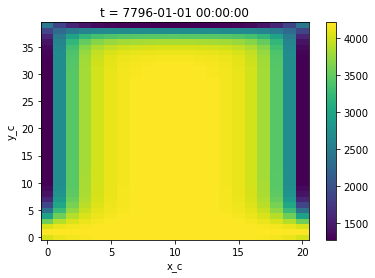

In [29]:
w_to = xbasin.remap_vertical(ds.woce*0+1, grid_fr, grid_to, axis='Z')
grid_to.integrate(w_to, axis='Z')[-1].plot()

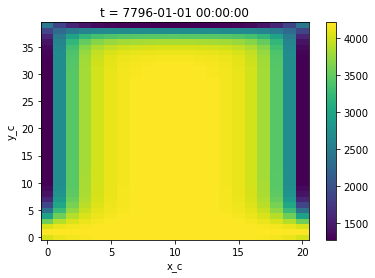

In [28]:
grid_fr.integrate((ds.woce*0+1), axis='Z')[-1].plot()

## Time comparison

The heart function of the remapping is computed from python to C++ with pythran, which improves the speed. However if pythran is not installed, the original python function is called instead.
As a user, you should not use the 2 following functions, they are only shown here for the time comparison.

In [7]:
fake_dataset = [
    np.ascontiguousarray(ds.gdept_0.values.reshape(ds.gdept_0.values.shape+(1,))),
    np.ascontiguousarray(ds.gdepw_0.values.reshape(ds.gdepw_0.values.shape+(1,))),
    np.ascontiguousarray(ds.thetao.transpose('z_c', 'y_c', 'x_c', 't').values.flatten().reshape(ds.thetao.transpose('z_c', 'y_c', 'x_c', 't').shape)[...,0:1])
]
from xbasin._interpolation import interp_new_vertical as _interpolation_pure_python
from xbasin.interpolation_compiled import interp_new_vertical as _interpolation_pythran

### Pure Python

In [8]:
%timeit _interpolation_pure_python(*fake_dataset)

120 ms ± 1.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Pythran

In [9]:
%timeit _interpolation_pythran(*fake_dataset)

2.66 ms ± 16.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


We see that the compiled version runs about 10-100 times faster (of course this number is just a rough approximation). The pure Python version does not use vectorized arrays and is thus slower.